# Предсказание рисков сердечного приступа

# Описание проекта:

    - В этом проекте предстоит разработать модель для предсказания риска сердечного приступа, используя данные пациентов, а также сделать для нее приложение на FastAPI для получения предсказаний по пользовательскому запросу.

# Задачи проекта:
    1. Разработать модель, которая будет предсказывать риск сердечного приступа.
    2. Подготовить данные для приложения на FastAPI.

### Загрузка данных

In [1]:
pip install -Uqq scikit-learn xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -qq missingno

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install -qq phik

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, OrdinalEncoder
from phik import phik_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

* Загрузим данные файлов heart_train и heart_test

In [5]:
heart_train = pd.read_csv('heart_train.csv')
with pd.option_context('display.max_columns', None):
    display(heart_train.head(10))

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047
5,5,0.168539,0.764286,0.057745,0.0,1.0,1.0,1.0,1.0,0.082682,1,1.0,0.0,7.0,0.558262,0.640836,0.110571,0.238961,6.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.464516,0.418605,5817
6,6,0.483146,0.021429,0.036664,1.0,0.0,1.0,0.0,1.0,0.540206,2,0.0,1.0,9.0,0.827611,0.774609,0.073718,0.072727,5.0,0.000000,1.0,0.231225,0.008940,0.000291,Male,0.361290,0.569767,5580
7,7,0.235955,0.939286,0.081577,1.0,0.0,1.0,0.0,1.0,0.290837,2,0.0,1.0,7.0,0.225275,0.999364,0.001534,0.180519,4.0,0.000000,0.0,0.227018,0.048229,0.036512,Male,0.690323,0.639535,4963
8,8,0.685393,0.317857,0.039413,0.0,0.0,1.0,0.0,0.0,0.803160,0,1.0,1.0,3.0,0.828176,0.142208,0.093073,0.990909,6.0,0.166667,1.0,0.126482,0.002332,0.007185,Male,0.664516,0.616279,4521
9,9,0.213483,0.796429,0.076994,1.0,1.0,1.0,1.0,0.0,0.506971,1,0.0,0.0,7.0,0.692973,0.820952,0.145447,0.171429,3.0,1.000000,0.0,0.227018,0.048229,0.036512,Male,0.651613,0.720930,2455


In [6]:
heart_test = pd.read_csv('heart_test.csv')
with pd.option_context('display.max_columns', None):
    display(heart_test.head())

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


* Начнем работу с файлом **heart_train**

In [7]:
heart_train.info()
heart_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047
5,5,0.168539,0.764286,0.057745,0.0,1.0,1.0,1.0,1.0,0.082682,...,6.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.464516,0.418605,5817
6,6,0.483146,0.021429,0.036664,1.0,0.0,1.0,0.0,1.0,0.540206,...,5.0,0.000000,1.0,0.231225,0.008940,0.000291,Male,0.361290,0.569767,5580
7,7,0.235955,0.939286,0.081577,1.0,0.0,1.0,0.0,1.0,0.290837,...,4.0,0.000000,0.0,0.227018,0.048229,0.036512,Male,0.690323,0.639535,4963
8,8,0.685393,0.317857,0.039413,0.0,0.0,1.0,0.0,0.0,0.803160,...,6.0,0.166667,1.0,0.126482,0.002332,0.007185,Male,0.664516,0.616279,4521
9,9,0.213483,0.796429,0.076994,1.0,1.0,1.0,1.0,0.0,0.506971,...,3.0,1.000000,0.0,0.227018,0.048229,0.036512,Male,0.651613,0.720930,2455


* **Проведем анализ по признакам и удалим нежнуные, которые в дальнейшем могут коррелировать, или есть дубликаты данных.**

* Признаки которые будем удалять:
    1. Unnamed: 0 – технический столбец.
    2. id – идентификатор пациента, не несёт информации для модели.
    3. Alcohol Consumption - влияние алкоголя на сердце неоднозначно (может быть как вред, так и польза в малых дозах, нет данных об алкогольной зависимости).
    4. Physical Activity Days Per Week - может дублироваться с Exercise Hours Per Week, лучше заниматься по чуть-чуть хотя бы, но регулярно.
    5. Medication Use - если лекарства принимаются из-за уже имеющихся проблем с сердцем, это может быть утечкой целевой переменной.
    6. Stress Level - субъективный признак.
    7. Income - косвенный признак, влияет через доступ к медицине, питанию.
    8. BMI - Можно заменить на Obesity, сейчас ожирение чаще определяют по объёму талии.
    9. Blood sugar -  есть Diabetes, более категоричный признак.
* Diastolic blood pressure - удалять не будем, обычно важнее систолическое давление, но пульсовое давление (разница между систолическим и диастолическим) – важный показатель. В дальнейшем можно будет создать новый признак.

* Удаляем ненужные столбцы

In [8]:
columns_to_drop = [
    "Unnamed: 0", 
    "id", 
    "Alcohol Consumption", 
    "Physical Activity Days Per Week", 
    "Medication Use", 
    "Stress Level", 
    "Income", 
    "BMI",
    "Blood sugar",
]
heart_train_cl = heart_train.drop(columns=columns_to_drop)
display(heart_train_cl.head(10))

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Exercise Hours Per Week,Diet,Previous Heart Problems,Sedentary Hours Per Day,Triglycerides,Sleep Hours Per Day,Heart Attack Risk (Binary),CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.225704,0.979221,0.333333,0.0,0.048229,0.036512,Male,0.212903,0.709302
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,0.068690,2,1.0,0.289923,0.515584,0.833333,0.0,0.017616,0.000194,Female,0.412903,0.569767
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,0.944001,2,1.0,0.550133,0.012987,1.000000,0.0,0.048229,0.036512,Female,0.238710,0.220930
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,0.697023,0,0.0,0.330962,0.131169,0.333333,1.0,0.048229,0.036512,Female,0.348387,0.267442
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,0.412878,1,0.0,0.524600,0.070130,1.000000,1.0,0.048229,0.036512,Male,0.619355,0.441860
5,0.168539,0.764286,0.057745,0.0,1.0,1.0,1.0,0.082682,1,1.0,0.558262,0.238961,0.833333,0.0,0.048229,0.036512,Male,0.464516,0.418605
6,0.483146,0.021429,0.036664,1.0,0.0,1.0,0.0,0.540206,2,0.0,0.827611,0.072727,0.000000,1.0,0.008940,0.000291,Male,0.361290,0.569767
7,0.235955,0.939286,0.081577,1.0,0.0,1.0,0.0,0.290837,2,0.0,0.225275,0.180519,0.000000,0.0,0.048229,0.036512,Male,0.690323,0.639535
8,0.685393,0.317857,0.039413,0.0,0.0,1.0,0.0,0.803160,0,1.0,0.828176,0.990909,0.166667,1.0,0.002332,0.007185,Male,0.664516,0.616279
9,0.213483,0.796429,0.076994,1.0,1.0,1.0,1.0,0.506971,1,0.0,0.692973,0.171429,1.000000,0.0,0.048229,0.036512,Male,0.651613,0.720930


* Супер, теперь можно заняться предобработкой данных

* **Вывод 1 шага:**
    1. Ознакомились с данными.
    2. Загрузили необходимые библиотеки, для дальнейшей работы над проектом.
    3. Провели анализ по признакам и избавились, от возможной мультиколлинеарности в будущем.

### Предобработка данных.

In [9]:
heart_train_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         8685 non-null   float64
 1   Cholesterol                 8685 non-null   float64
 2   Heart rate                  8685 non-null   float64
 3   Diabetes                    8442 non-null   float64
 4   Family History              8442 non-null   float64
 5   Smoking                     8442 non-null   float64
 6   Obesity                     8442 non-null   float64
 7   Exercise Hours Per Week     8685 non-null   float64
 8   Diet                        8685 non-null   int64  
 9   Previous Heart Problems     8442 non-null   float64
 10  Sedentary Hours Per Day     8685 non-null   float64
 11  Triglycerides               8685 non-null   float64
 12  Sleep Hours Per Day         8685 non-null   float64
 13  Heart Attack Risk (Binary)  8685 

* Проверим данные на дубликаты/пропуски/баланс классов

In [10]:
print('Пропуски:\n', heart_train_cl.isnull().sum())

Пропуски:
 Age                             0
Cholesterol                     0
Heart rate                      0
Diabetes                      243
Family History                243
Smoking                       243
Obesity                       243
Exercise Hours Per Week         0
Diet                            0
Previous Heart Problems       243
Sedentary Hours Per Day         0
Triglycerides                   0
Sleep Hours Per Day             0
Heart Attack Risk (Binary)      0
CK-MB                           0
Troponin                        0
Gender                          0
Systolic blood pressure         0
Diastolic blood pressure        0
dtype: int64


<AxesSubplot:>

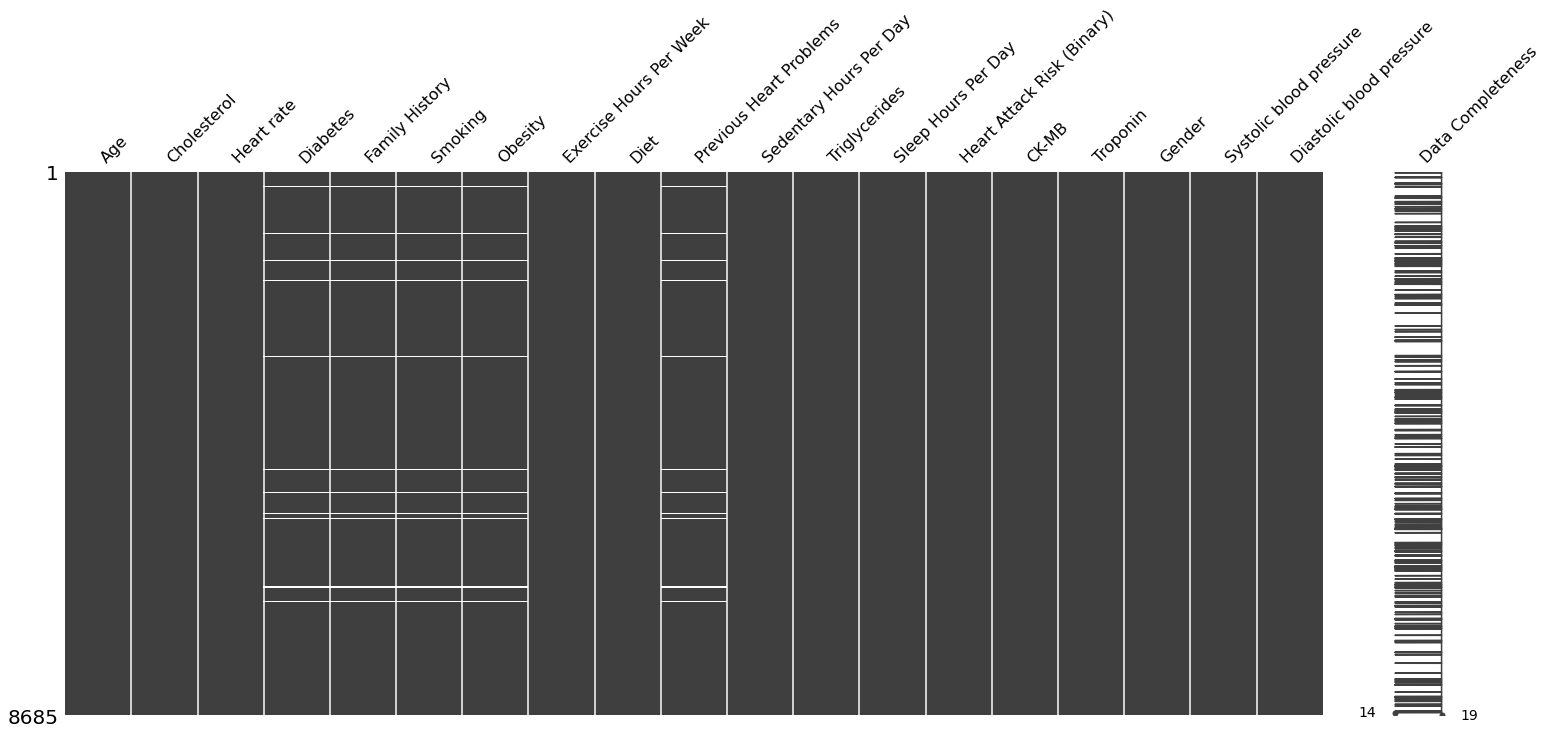

In [11]:
msno.matrix(heart_train_cl, labels=True)

* Пропущенных значений < 5% от всей выборки, можем удалить их

In [12]:
columns_with_nulls = heart_train_cl.columns[heart_train_cl.isnull().any()]
heart_train_cl = heart_train_cl.dropna(subset=columns_with_nulls)

<AxesSubplot:>

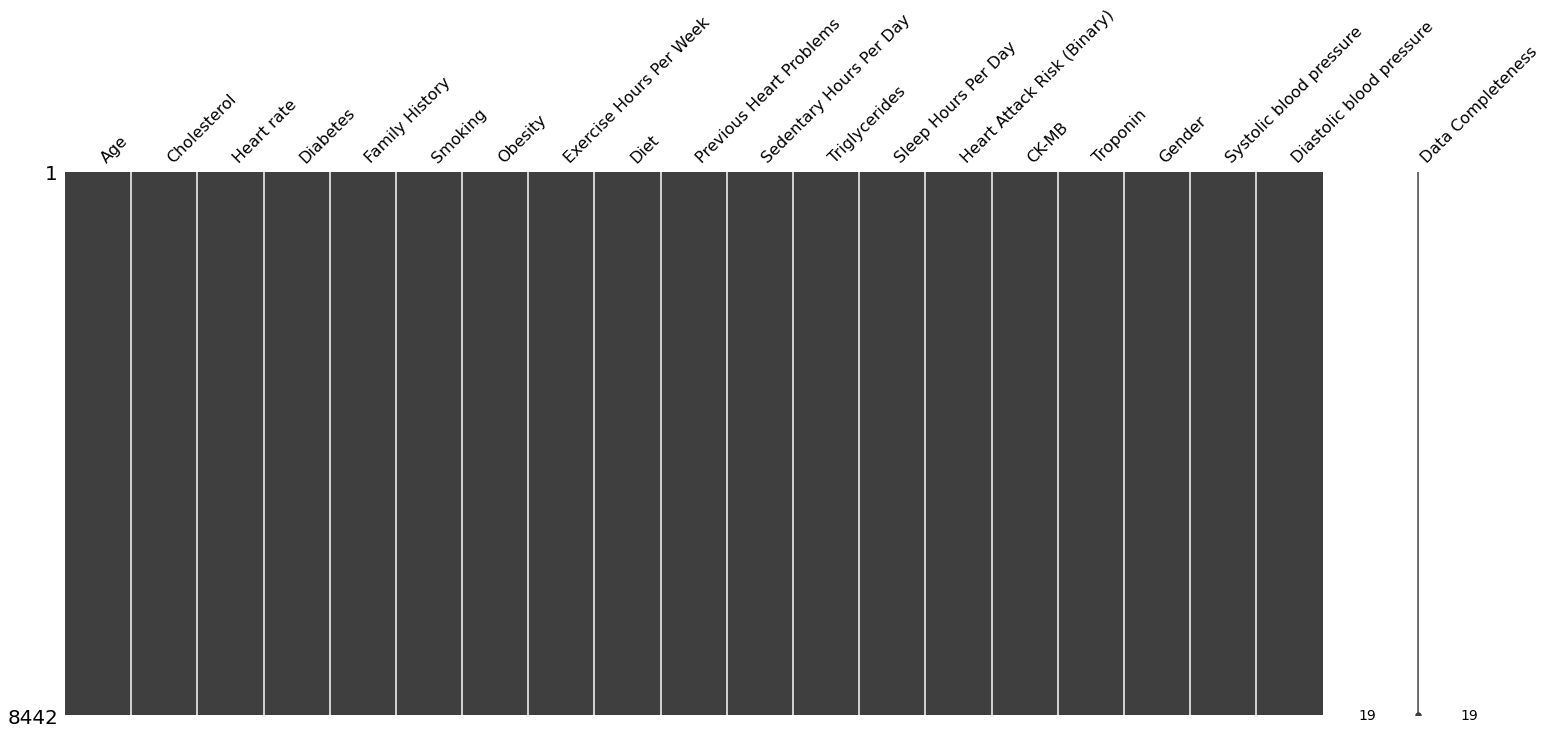

In [13]:
msno.matrix(heart_train_cl, labels=True)

* Избавились от пропусков

In [14]:
heart_train_cl['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [15]:
print('Дубликаты:\n', heart_train_cl.duplicated().sum())

Дубликаты:
 0


In [16]:
print('\nБаланс классов:\n', heart_train_cl['Heart Attack Risk (Binary)'].value_counts())


Баланс классов:
 0.0    5429
1.0    3013
Name: Heart Attack Risk (Binary), dtype: int64


* Займемся преобразованием типов.

In [17]:
heart_train_cl.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Exercise Hours Per Week,Diet,Previous Heart Problems,Sedentary Hours Per Day,Triglycerides,Sleep Hours Per Day,Heart Attack Risk (Binary),CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.225704,0.979221,0.333333,0.0,0.048229,0.036512,Male,0.212903,0.709302
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,0.068690,2,1.0,0.289923,0.515584,0.833333,0.0,0.017616,0.000194,Female,0.412903,0.569767
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,0.944001,2,1.0,0.550133,0.012987,1.000000,0.0,0.048229,0.036512,Female,0.238710,0.220930
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,0.697023,0,0.0,0.330962,0.131169,0.333333,1.0,0.048229,0.036512,Female,0.348387,0.267442
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,0.412878,1,0.0,0.524600,0.070130,1.000000,1.0,0.048229,0.036512,Male,0.619355,0.441860


In [18]:
binary_cols = ['Diabetes', 'Family History', 'Smoking', 'Obesity', 'Previous Heart Problems']
heart_train_cl[binary_cols] = heart_train_cl[binary_cols].astype('int8')

In [19]:
heart_train_cl["Diet"] = heart_train_cl["Diet"].astype("category")
heart_train_cl["Gender"] = heart_train_cl["Gender"].astype("category")

In [20]:
heart_train_cl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8442 entries, 0 to 8684
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Age                         8442 non-null   float64 
 1   Cholesterol                 8442 non-null   float64 
 2   Heart rate                  8442 non-null   float64 
 3   Diabetes                    8442 non-null   int8    
 4   Family History              8442 non-null   int8    
 5   Smoking                     8442 non-null   int8    
 6   Obesity                     8442 non-null   int8    
 7   Exercise Hours Per Week     8442 non-null   float64 
 8   Diet                        8442 non-null   category
 9   Previous Heart Problems     8442 non-null   int8    
 10  Sedentary Hours Per Day     8442 non-null   float64 
 11  Triglycerides               8442 non-null   float64 
 12  Sleep Hours Per Day         8442 non-null   float64 
 13  Heart Attack Risk 

* Так же как было описано выше, создадим новый признак, **"Pulse Pressure"**. Pulse Pressure = Systolic - Diastolic. Важный показатель.

In [21]:
heart_train_cl["Pulse Pressure"] = heart_train_cl["Systolic blood pressure"] - heart_train_cl["Diastolic blood pressure"]
heart_train_cl.head()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Exercise Hours Per Week,Diet,Previous Heart Problems,Sedentary Hours Per Day,Triglycerides,Sleep Hours Per Day,Heart Attack Risk (Binary),CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,Pulse Pressure
0,0.359551,0.732143,0.074244,1,1,1,1,0.535505,1,1,0.225704,0.979221,0.333333,0.0,0.048229,0.036512,Male,0.212903,0.709302,-0.496399
1,0.202247,0.325000,0.047663,1,1,0,0,0.068690,2,1,0.289923,0.515584,0.833333,0.0,0.017616,0.000194,Female,0.412903,0.569767,-0.156864
2,0.606742,0.860714,0.055912,1,0,1,1,0.944001,2,1,0.550133,0.012987,1.000000,0.0,0.048229,0.036512,Female,0.238710,0.220930,0.017779
3,0.730337,0.007143,0.053162,0,0,1,0,0.697023,0,0,0.330962,0.131169,0.333333,1.0,0.048229,0.036512,Female,0.348387,0.267442,0.080945
4,0.775281,0.757143,0.021998,0,0,1,0,0.412878,1,0,0.524600,0.070130,1.000000,1.0,0.048229,0.036512,Male,0.619355,0.441860,0.177494


In [22]:
heart_train_cl.describe()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Exercise Hours Per Week,Previous Heart Problems,Sedentary Hours Per Day,Triglycerides,Sleep Hours Per Day,Heart Attack Risk (Binary),CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,Pulse Pressure
count,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000
mean,0.449008,0.501108,0.050194,0.652097,0.489576,0.902867,0.498342,0.503415,0.495380,0.499142,0.505539,0.503712,0.356906,0.047745,0.036867,0.451955,0.501672,-0.049718
std,0.232809,0.288785,0.018442,0.476333,0.499921,0.296157,0.500027,0.288881,0.500008,0.289418,0.290412,0.332749,0.479115,0.070399,0.059284,0.170187,0.170302,0.238504
min,0.044944,0.000000,0.018332,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.161290,0.209302,-0.629407
25%,0.247191,0.260714,0.034830,0.000000,0.000000,1.000000,0.000000,0.253359,0.000000,0.247650,0.257143,0.166667,0.000000,0.048229,0.036512,0.303226,0.348837,-0.218886
50%,0.460674,0.496429,0.050412,1.000000,0.000000,1.000000,0.000000,0.508244,0.000000,0.492734,0.507792,0.500000,0.000000,0.048229,0.036512,0.451613,0.500000,-0.052326
75%,0.640449,0.750000,0.065995,1.000000,1.000000,1.000000,1.000000,0.754901,1.000000,0.751047,0.758442,0.833333,1.000000,0.048229,0.036512,0.600000,0.651163,0.119261
max,0.853933,1.000000,0.082493,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.741935,0.790698,0.532633


* Промежуточный вывод:
    - Большая часть признаков, отмасштабирована, по типу столбца Age, так же есть категориальные и бинарные признаки.
    - Выбросов не наблюдается

* Теперь предобработка для тестовых данных

In [23]:
heart_test.head()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,...,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,...,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,...,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,...,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,...,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


In [24]:
heart_test_cl = heart_test.drop(columns=columns_to_drop)
heart_test_cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       966 non-null    float64
 1   Cholesterol               966 non-null    float64
 2   Heart rate                966 non-null    float64
 3   Diabetes                  935 non-null    float64
 4   Family History            935 non-null    float64
 5   Smoking                   935 non-null    float64
 6   Obesity                   935 non-null    float64
 7   Exercise Hours Per Week   966 non-null    float64
 8   Diet                      966 non-null    int64  
 9   Previous Heart Problems   935 non-null    float64
 10  Sedentary Hours Per Day   966 non-null    float64
 11  Triglycerides             966 non-null    float64
 12  Sleep Hours Per Day       966 non-null    float64
 13  CK-MB                     966 non-null    float64
 14  Troponin  

* Изменим тип данных некоторых признаков

In [25]:
print('Дубликаты:\n', heart_test_cl.duplicated().sum())

Дубликаты:
 0


* Пропуски и дубликаты будем обрабатывать в Pipeline

In [26]:
heart_test_cl.describe()

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Exercise Hours Per Week,Diet,Previous Heart Problems,Sedentary Hours Per Day,Triglycerides,Sleep Hours Per Day,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure
count,966.000000,966.000000,966.000000,935.000000,935.000000,935.000000,935.000000,966.000000,966.000000,935.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000
mean,0.452916,0.488181,0.051644,0.656684,0.481283,0.898396,0.516578,0.490706,1.053830,0.494118,0.506715,0.486688,0.512571,0.048855,0.034926,0.447172,0.496822
std,0.231068,0.282039,0.035502,0.475070,0.499917,0.302289,0.499993,0.284902,0.884642,0.500233,0.287826,0.284534,0.322292,0.079742,0.053855,0.171837,0.173935
min,0.044944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000336,0.000000,0.000000,0.001187,0.000000,0.000000,0.000000,0.000194,0.012903,0.116279
25%,0.247191,0.243750,0.036664,0.000000,0.000000,1.000000,0.000000,0.243431,0.000000,0.000000,0.258713,0.249675,0.166667,0.048229,0.036512,0.296774,0.348837
50%,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,1.000000,0.502110,1.000000,0.000000,0.501327,0.488961,0.500000,0.048229,0.036512,0.445161,0.488372
75%,0.640449,0.710714,0.065995,1.000000,1.000000,1.000000,1.000000,0.734425,2.000000,1.000000,0.759591,0.718182,0.833333,0.048229,0.036512,0.600000,0.639535
max,0.853933,0.996429,1.000000,1.000000,1.000000,1.000000,1.000000,0.998938,3.000000,1.000000,0.999033,0.998701,1.000000,1.000000,0.970871,0.741935,0.790698


* Данные так же отмасштабированны уже, есть категориальные и бинарные, позже изменим типы данных, выбросов не наблюдается.

* Первоначальная подготовка данных (без преобразований)

In [27]:
# Сохраняем ID для финального submission
train_ids = heart_train['id'].copy()
test_ids = heart_test['id'].copy()

* Определяем типы признаков

In [28]:
numerical_features = ['Age', 'Cholesterol', 'Heart rate', 'Exercise Hours Per Week', 
                     'Systolic blood pressure', 'Diastolic blood pressure', 'CK-MB', 'Troponin']
binary_features = ['Diabetes', 'Smoking', 'Obesity', 'Family History', 'Previous Heart Problems']
categorical_features = ['Gender', 'Diet']

In [29]:
X_train = heart_train_cl.drop('Heart Attack Risk (Binary)', axis=1)
y_train = heart_train_cl['Heart Attack Risk (Binary)']
X_test = heart_test_cl.copy()

* **Вывод 2 шага:**
    1. Провели предобработку данных, которая в себя включала:
        1. Нахождение/удаление - пропусков/дубликатов.
        2. Изменение типов данных у определенных признаков, для дальнейшей корректной работы с данными.
        3. Ознакомились с данными train и test через DESCRIBE, отметили для себя, что уже наблюдаются отмасштабированные данные, категориальные и бинарные.
        4. Выбросов не наблюдается.

### Исследовательский анализ данных

* Общая информация

In [30]:
print("Тренировочные данные:")
display(heart_train_cl.info())
print("\nТестовые данные:")
display(heart_test_cl.info())

Тренировочные данные:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8442 entries, 0 to 8684
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Age                         8442 non-null   float64 
 1   Cholesterol                 8442 non-null   float64 
 2   Heart rate                  8442 non-null   float64 
 3   Diabetes                    8442 non-null   int8    
 4   Family History              8442 non-null   int8    
 5   Smoking                     8442 non-null   int8    
 6   Obesity                     8442 non-null   int8    
 7   Exercise Hours Per Week     8442 non-null   float64 
 8   Diet                        8442 non-null   category
 9   Previous Heart Problems     8442 non-null   int8    
 10  Sedentary Hours Per Day     8442 non-null   float64 
 11  Triglycerides               8442 non-null   float64 
 12  Sleep Hours Per Day         8442 non-null   float64 
 

None


Тестовые данные:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       966 non-null    float64
 1   Cholesterol               966 non-null    float64
 2   Heart rate                966 non-null    float64
 3   Diabetes                  935 non-null    float64
 4   Family History            935 non-null    float64
 5   Smoking                   935 non-null    float64
 6   Obesity                   935 non-null    float64
 7   Exercise Hours Per Week   966 non-null    float64
 8   Diet                      966 non-null    int64  
 9   Previous Heart Problems   935 non-null    float64
 10  Sedentary Hours Per Day   966 non-null    float64
 11  Triglycerides             966 non-null    float64
 12  Sleep Hours Per Day       966 non-null    float64
 13  CK-MB                     966 non-null    float

None

* **Анализ категориальных признаков (Gender, Diet)**

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


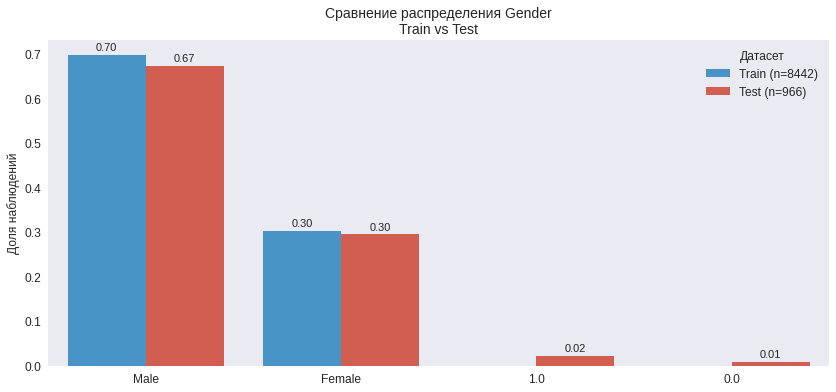

posx and posy should be finite values
posx and posy should be finite values


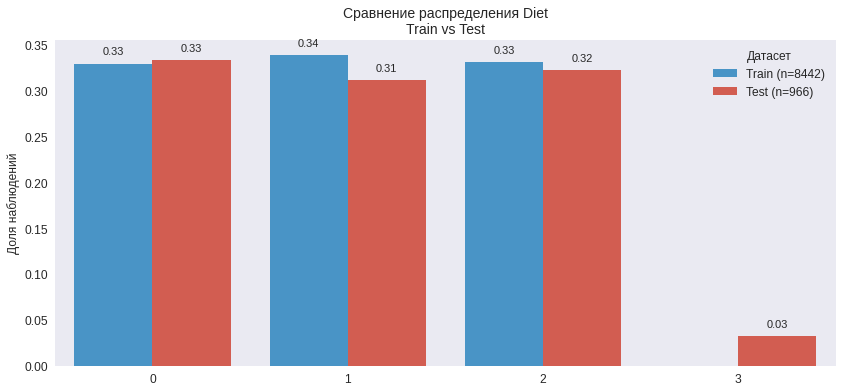

In [31]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (14, 6)

for feature in categorical_features:
    train_counts = heart_train_cl[feature].value_counts(normalize=True).reset_index()
    train_counts.columns = [feature, 'proportion']
    train_counts['dataset'] = 'Train (n=8442)'
    
    test_counts = heart_test_cl[feature].value_counts(normalize=True).reset_index()
    test_counts.columns = [feature, 'proportion']
    test_counts['dataset'] = 'Test (n=966)'
    
    combined = pd.concat([train_counts, test_counts])
    
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(data=combined, x=feature, y='proportion', hue='dataset', 
                    palette=['#3498db', '#e74c3c'])
    
    plt.title(f'Сравнение распределения {feature}\nTrain vs Test', fontsize=14)
    plt.xlabel('')
    plt.ylabel('Доля наблюдений', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', fontsize=11)
    
    plt.legend(title='Датасет', title_fontsize=12, fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

* Анализ распределений категориальных признаков:
    1. Признак Gender (Пол)
        Распределение в train/test:
            - Мужчины: 70% (train) vs 67% (test)
            - Женщины: 30% (train) vs 30% (test)
    Выводы:
        1. Небольшой дисбаланс в сторону мужчин 70/30 сохраняется в обоих наборах
        2. Незначительное расхождение по мужчинам -3% в test - в пределах допустимого
        3. Рекомендации:
            - Учитывать пол как важный фактов (мужчины в группе риска)
            - Проверить, как соотношение влияет на целевую переменную
        
    2. Признак Diet (Тип питания)
        Распределение в train/test:
            - Тип 0: 33% / 33%
            - Тип 1: 34% / 31%
            - Тип 2: 33% / 32%
    Выводы:
        1. Сбалансированное распределение между основными типами питания
        2. Минимальные различия между train и test (разница <= 3%)
        3. Рекомендации:
            - Проверить корреляцию типа питания с целевой переменной

* **Проверка связи с целевой переменной**

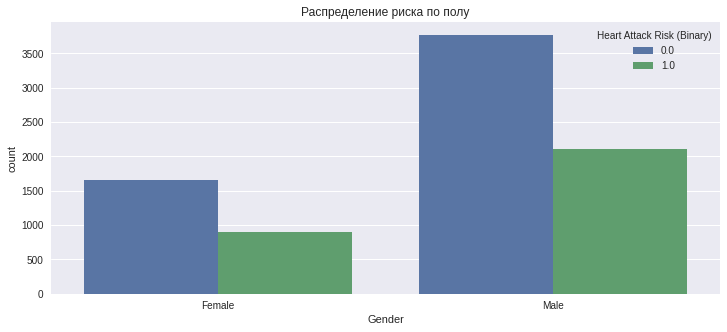

In [32]:
plt.figure(figsize=(12, 5))
sns.countplot(data=heart_train_cl, x='Gender', hue='Heart Attack Risk (Binary)')
plt.title('Распределение риска по полу')
plt.show()

* Большой дисбаланс по полу указывает на нормальное распределение предсказаний

* **Связь риска с питанием**

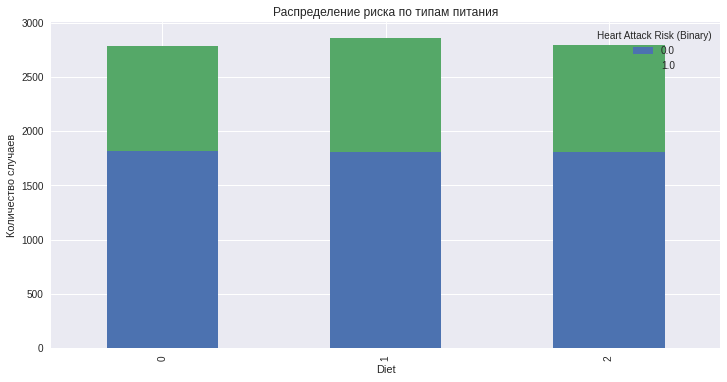

In [33]:
pd.crosstab(heart_train_cl['Diet'], heart_train_cl['Heart Attack Risk (Binary)'])\
  .plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Распределение риска по типам питания')
plt.ylabel('Количество случаев')
plt.show()

* Разные категории диеты (Diet) демонстрируют схожее соотношение пациентов с высоким (1.0) и низким (0) риском сердечного приступа
* Это указывает на статистически значимую связь между типом питания и сердечно-сосудистым здоровьем
* Для Diet=1 : пропорция высокого риска ~ на 100 случаев выше

    - Практические выводы:
    1. Тип питания не является важным предиктором в модели

* **Анализ бинарных признаков (с разделением по целевой переменной)**

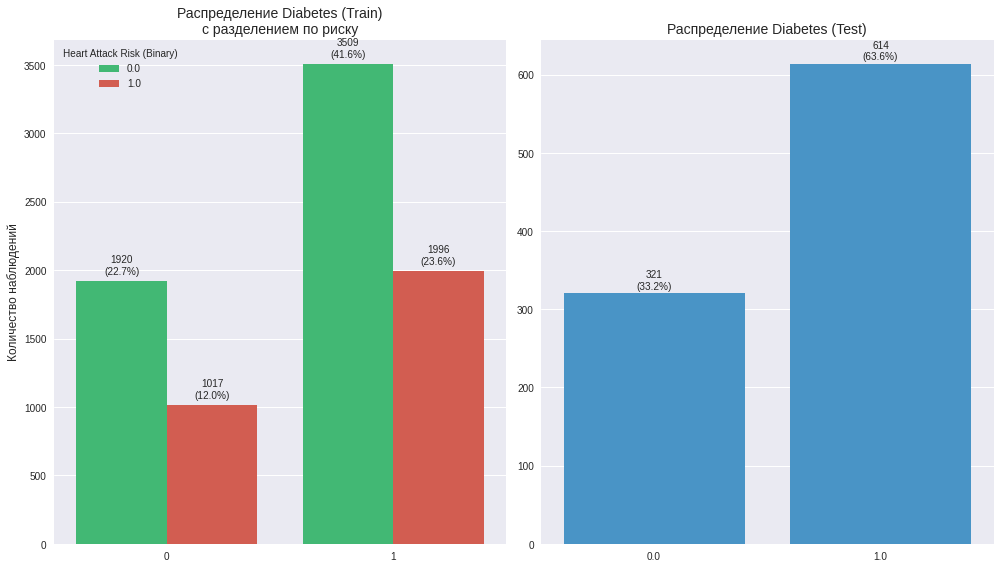

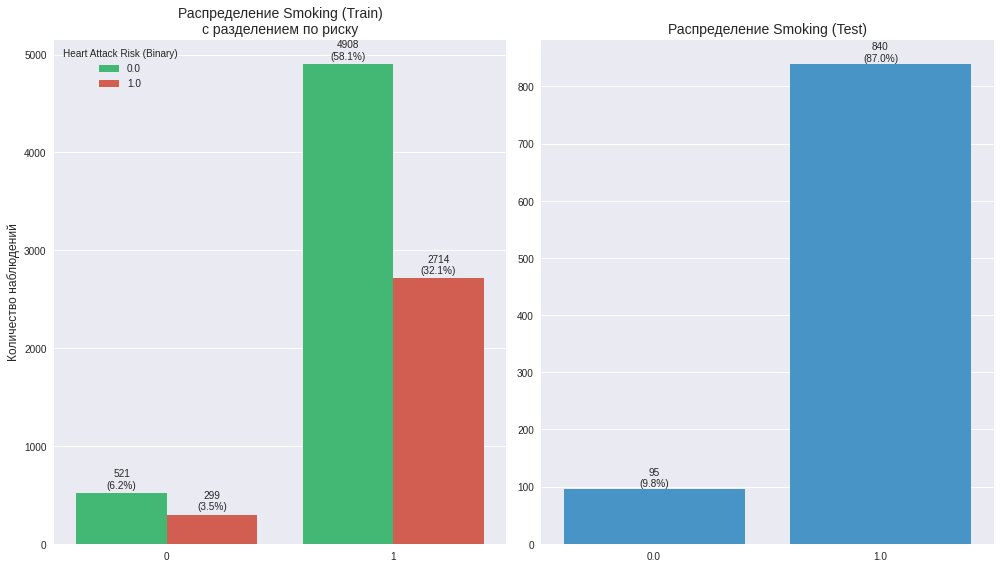

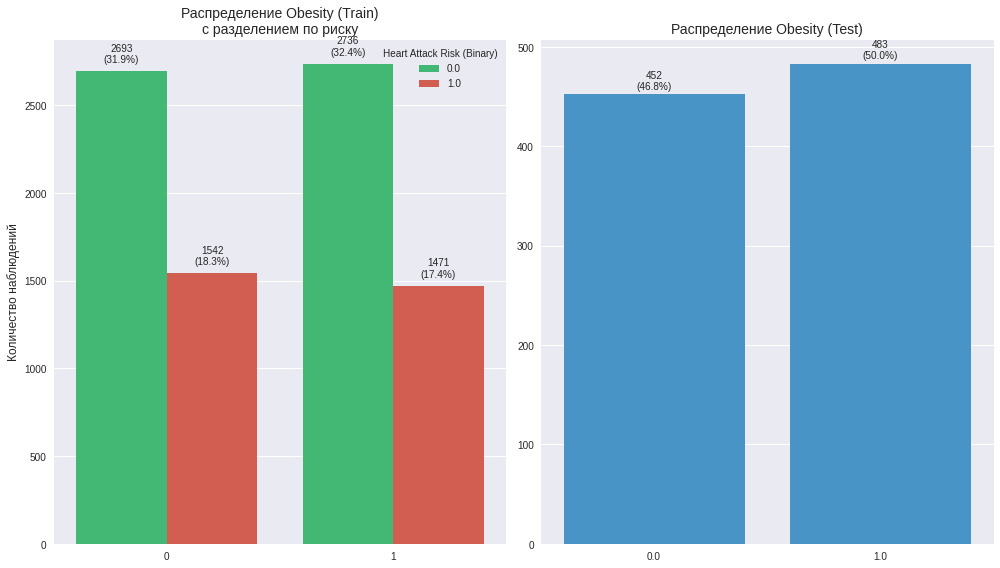

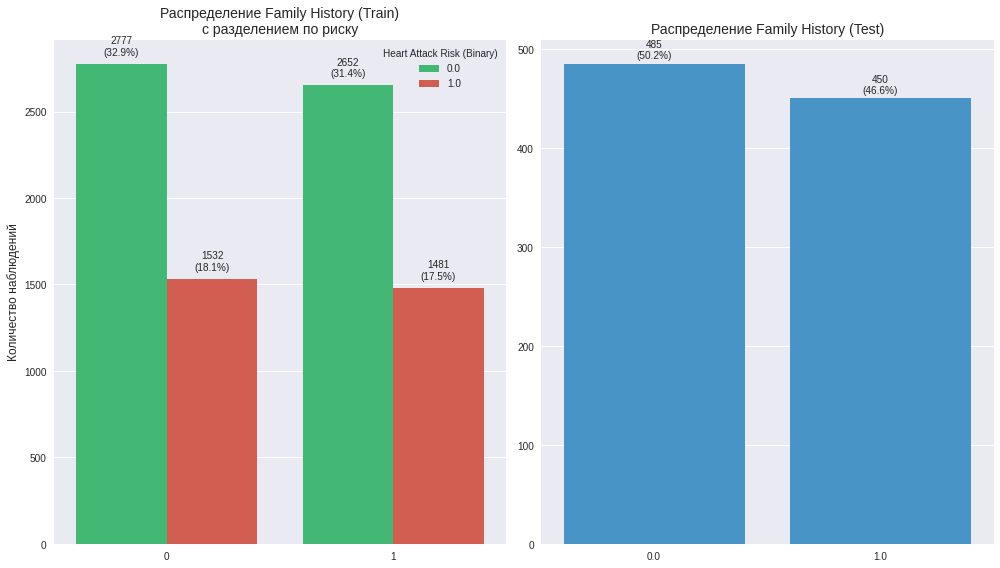

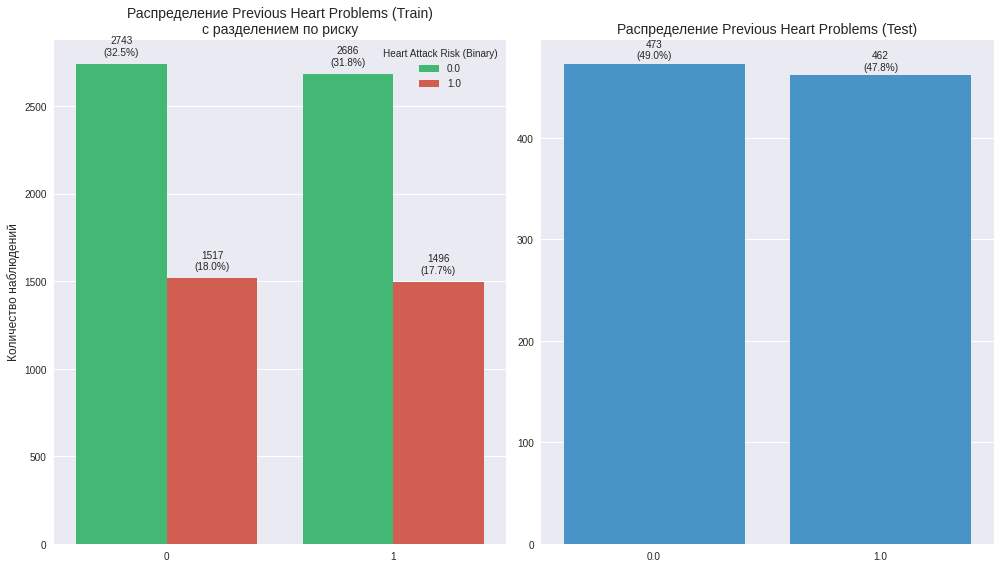

In [34]:
for feature in binary_features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
    
    sns.countplot(data=heart_train_cl, x=feature, hue='Heart Attack Risk (Binary)',
                 palette=['#2ecc71', '#e74c3c'], ax=ax1)
    ax1.set_title(f'Распределение {feature} (Train)\nс разделением по риску', fontsize=14)
    ax1.set_xlabel('')
    ax1.set_ylabel('Количество наблюдений', fontsize=12)
    
    sns.countplot(data=heart_test_cl, x=feature, palette=['#3498db'], ax=ax2)
    ax2.set_title(f'Распределение {feature} (Test)', fontsize=14)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    
    # Добавляем проценты для train
    for p in ax1.patches:
        height = p.get_height()
        total = len(heart_train_cl)
        ax1.text(p.get_x() + p.get_width()/2., height + 50,
                f'{height}\n({height/total:.1%})', 
                ha='center', fontsize=10)
    
    # Добавляем проценты для test
    for p in ax2.patches:
        height = p.get_height()
        total = len(heart_test_cl)
        ax2.text(p.get_x() + p.get_width()/2., height + 5,
                f'{height}\n({height/total:.1%})', 
                ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

* Промежуточные выводы:

**Признак Diabetes**

    1. Распределение Diabetes в тренировочной выборке:
        1. Большинство пациентов имеют Diabetes=1 (около 58% суммарно, 41.6% без риска + 23.6% с риском).
        2. Пациентов без диабета (Diabetes=0) меньше - около 41% (22.7% без риска + 12% с риском).
        3. Более высокий процент риска сердечного приступа у пациентов с диабетом(23.6% против 12% у без диабета).
        4. Это говорит о позитивной корреляции между наличием диабета и риском сердечного приступа.
    2. Распределение Diabetes в тестовой выборке:
        1. Соотношение диабетиков и не диабетиков менее сбалансировано: диабетиков около 63.6%, не диабетиков 33.2%.
    3. Общие рекомендации:
        1. Признак Diabetes явно информативен для задачи, так как риск у диабетиков выше.
        2. В модели стоит учитывать Diabetes как важный фактор.

**Признак Smoking**

    1. В тренировочном наборе:
        1. Большинство пациентов — курильщики (около 82%, сумма 58.1% + 32.1%), причем среди курильщиков риск сердечного приступа (32.1%) существенно выше, чем среди некурящих (3.5%).
        2. Не курят около 18% пациентов, и среди них риск сердечного приступа значительно ниже (3.5% с риском против 32.1% у курящих).
        3. Это подтверждает, что курение — важный и сильный фактор риска сердечного приступа.
    2. В тестовом наборе:
        1. Процент курильщиков очень высокий — около 87% (840 из 966).
        2. Не курящих всего 9.8% (95 человек).
        3. Распределение курильщиков в тесте ещё более смещено в сторону курящих, чем в тренировочном наборе.
    3. Выводы и рекомендации:
        1. Курение явно связано с повышенным риском — данный признак следует обязательно учитывать в модели.
        2. Дисбаланс между train и test по признаку курения — в тестовой выборке больше курильщиков, чем в тренировочной. Это может повлиять на качество предсказаний, особенно если модель сильно полагается на этот признак.
        
**Признак Obesity**

    1. В тренировочной выборке:
        1. Наблюдается почти равное количество пациентов с ожирением (1) и без ожирения (0):
        2. Без ожирения: ~31.9% без риска и ~18.3% с риском. С ожирением: ~32.4% без риска и ~17.4% с риском.
        3. Риск сердечного приступа примерно одинаково распределён между группами с ожирением и без ожирения (около 35-36% с риском в каждой группе).
        4. Это говорит о том, что ожирение может не быть сильно выраженным отдельным фактором риска в данной выборке — либо его влияние перекрывается другими признаками.
    2. В тестовой выборке:
        1. Распределение почти равномерное — 46.8% без ожирения и 50% с ожирением.
        2. Доля пациентов с ожирением чуть выше, чем без.
    3. Выводы и рекомендации:
        1. Ожирение в данной выборке не демонстрирует ярко выраженной корреляции с риском сердечного приступа. Возможно, оно влияет на риск в сочетании с другими факторами (например, диабетом, курением, гипертонией).
        2. В тестовом наборе распределение ожирения близко к тренировочному, что хорошо для обобщения модели.

**Признак Family History**

    1. В тренировочной выборке:
        1. Пациенты без семейного анамнеза (0) и с семейным анамнезом (1) представлены примерно в равных долях:
        2. Без семейного анамнеза: 32.9% без риска и 18.1% с риском. С семейным анамнезом: 31.4% без риска и 17.5% с риском.
        3. Разница в риске сердечного приступа между группами незначительна — наличие семейного анамнеза не сильно меняет вероятность риска в данном датасете.
    2. В тестовой выборке:
        1. Распределение также близко к равномерному: примерно 50.2% без семейного анамнеза, 46.6% с семейным анамнезом.
        2. Соотношения примерно соответствуют тренировочной выборке.
    3. Выводы:
        1. Признак Family History в текущем датасете не демонстрирует сильной связи с риском сердечного приступа.
        2. Распределение признака в тестовой выборке близко к тренировочной — это хорошо для стабильности модели.
        
**Признак Previous Heart Problems**

    1. В тренировочной выборке:
        1. Примерно равное количество пациентов с наличием и отсутствием предшествующих сердечных проблем.
        2. Без предшествующих проблем: около 32.5% без риска и 18.0% с риском. С предшествующими проблемами: около 31.8% без риска и 17.7% с риском.
        3. Разница в распределении риска сердечного приступа между группами невелика — наличие предыдущих проблем не сильно увеличивает риск в данной выборке.
    2. В тестовой выборке:
        1. Распределение примерно равномерное: Без предыдущих проблем — 49.0%. С предыдущими проблемами — 47.8%.
        2. Такая сбалансированность хороша для стабильности и обобщаемости модели.
    3. Выводы:
        1. Признак Previous Heart Problems не показывает ярко выраженной корреляции с таргетом в текущем датасете.
        2. Распределения в train и test схожи, что положительно сказывается на устойчивости модели.

* **Анализ числовых признаков (сравнение распределений)**

* В признаках **Heart rate, CK-MB и Troponin** будут выбросы, обработаем их 

In [35]:
def cap_outliers(df, feature, lower_percentile=0.01, upper_percentile=0.99):
    lower = df[feature].quantile(lower_percentile)
    upper = df[feature].quantile(upper_percentile)
    df[feature] = df[feature].clip(lower, upper)
    return df

# Обработка CK-MB и Troponin
for feature in ['CK-MB', 'Troponin']:
    heart_train_cl = cap_outliers(heart_train_cl, feature)
    heart_test_cl = cap_outliers(heart_test_cl, feature)
    
    # Логарифмическое преобразование с добавлением малого значения для избежания log(0)
    epsilon = 1e-6
    heart_train_cl[f'{feature}_log'] = np.log(heart_train_cl[feature] + epsilon)
    heart_test_cl[f'{feature}_log'] = np.log(heart_test_cl[feature] + epsilon)

# Ограничение выбросов для Heart rate
heart_train_cl = cap_outliers(heart_train_cl, 'Heart rate')
heart_test_cl = cap_outliers(heart_test_cl, 'Heart rate')

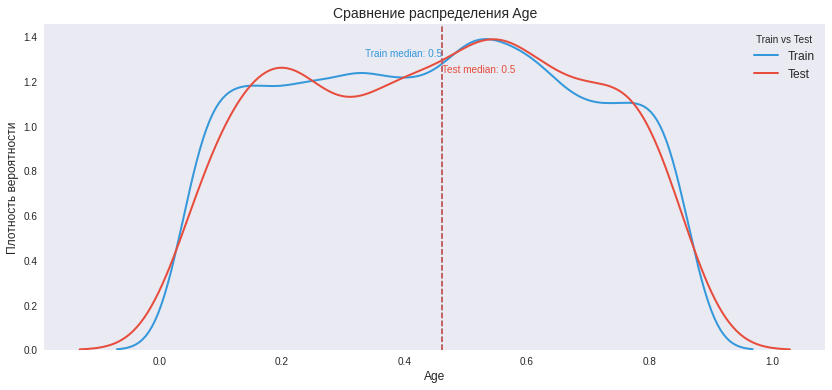

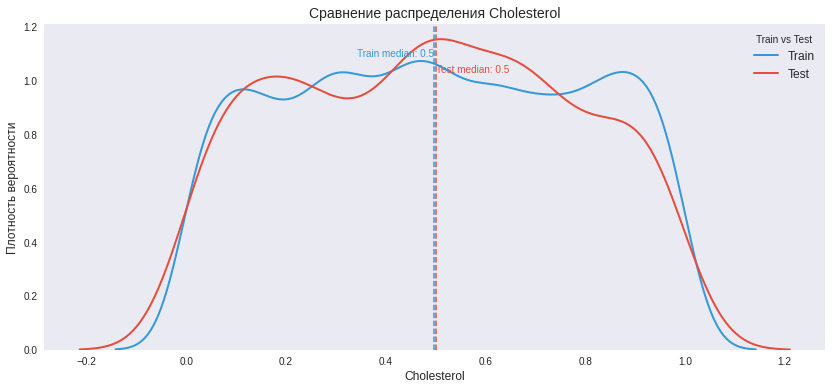

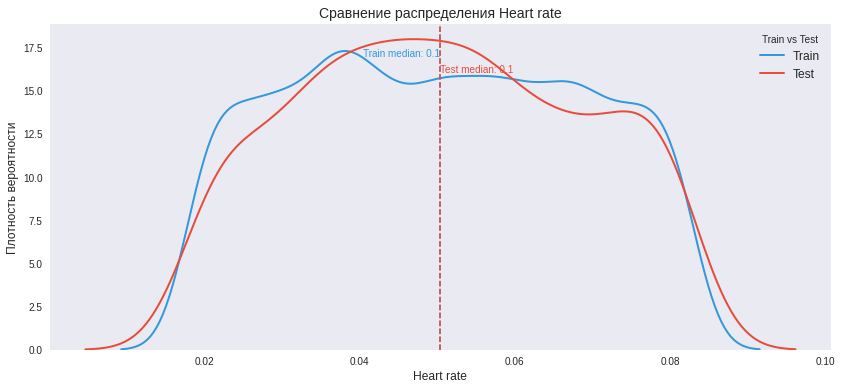

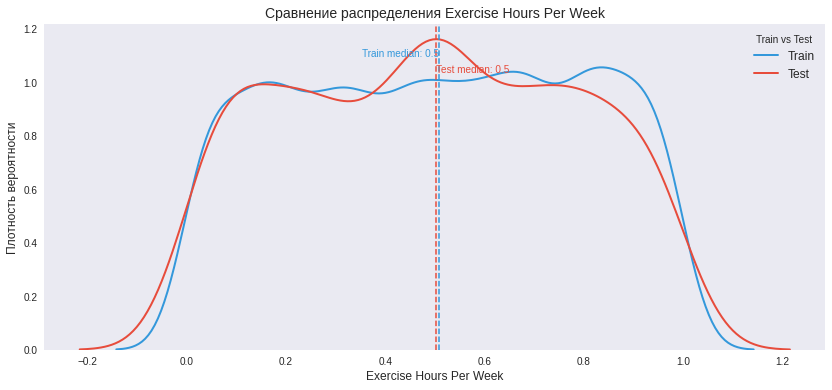

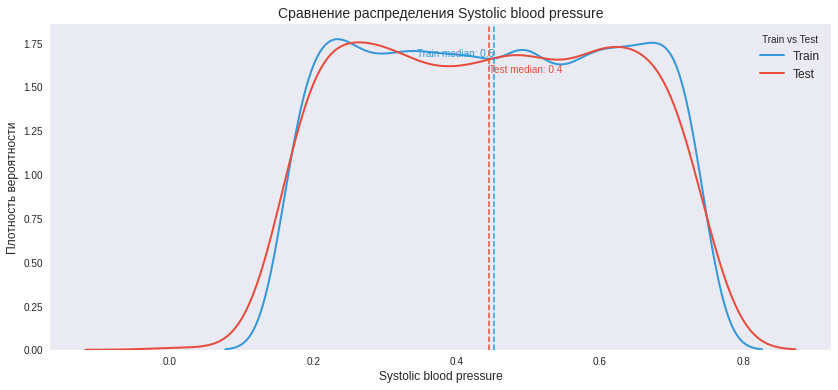

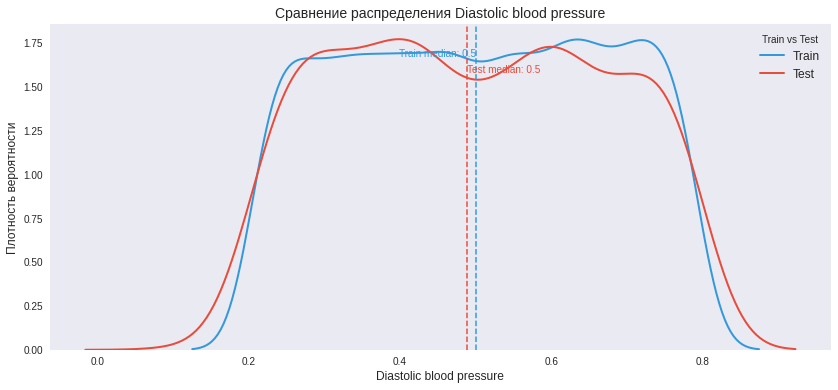

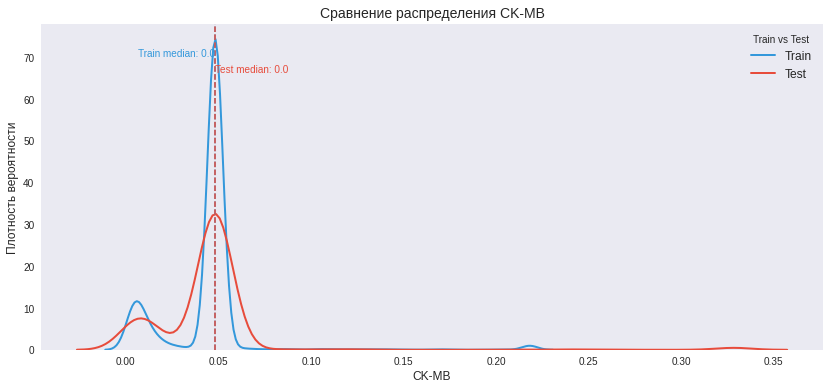

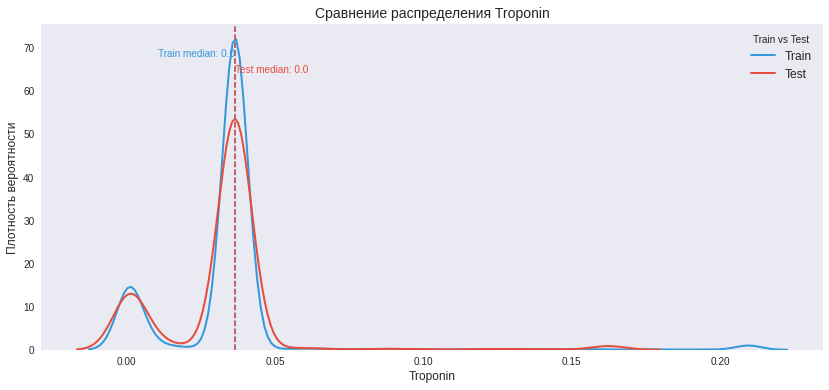

In [36]:
for feature in numerical_features:
    plt.figure(figsize=(14, 6))
    
    # KDE plot с нормализацией
    sns.kdeplot(data=heart_train_cl, x=feature, label='Train', 
               color='#3498db', linewidth=2, alpha=0.7)
    sns.kdeplot(data=heart_test_cl, x=feature, label='Test', 
               color='#e74c3c', linewidth=2, alpha=0.7)
    
    plt.title(f'Сравнение распределения {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Плотность вероятности', fontsize=12)
    plt.legend(title=f'Train vs Test', fontsize=12)
    
    # Добавляем медианы
    train_median = heart_train_cl[feature].median()
    test_median = heart_test_cl[feature].median()
    
    plt.axvline(train_median, color='#3498db', linestyle='--', linewidth=1.5)
    plt.axvline(test_median, color='#e74c3c', linestyle='--', linewidth=1.5)
    
    plt.text(train_median, plt.ylim()[1]*0.9, f'Train median: {train_median:.1f}',
             color='#3498db', ha='right')
    plt.text(test_median, plt.ylim()[1]*0.85, f'Test median: {test_median:.1f}',
             color='#e74c3c', ha='left')
    
    plt.grid(alpha=0.3)
    plt.show()

* Промежуточные выводы:
    1. Признак Age:
        1. Распределение похоже на равномерное с несколькими пиками.
        2. Медианы train и test почти совпадают.
        3. Выбросов нет.
    2. Признак Cholesterol:
        1. Распределение с несколькими пиками.
        2. Разница в медианах незначительна.
        3. Выбросов не наблюдается.
    3. Признак Heart rate:
        1. Распределения тренировочного и тестового наборов стали ещё более схожими.
        2. Убраны экстремальные выбросы, плотность распределения стала более ровной и компактной.
        3. Медианы в train и test практически совпадают — это хороший признак согласованности.
    4. Признак Exercise Hours Per Week:
        1. Распределение близко к равномерному с небольшими пиками, без ярких выбросов.
        2. Обработка выбросов, скорее всего, не нужна.
    5. Признаки Systolic blood pressure и Diastolic blood pressure:
        1. Распределения похожи на двухпиковые.
        2. Видно небольшие отличия в медианах train и test.
        3. Выбросов явно не видно, но стоит проверить экстремальные значения.
    6. Признаки CK-MB и Troponin:
        1. Удалось существенно сократить хвосты выбросов, распределения стали более сконцентрированными вокруг медианы.
        2. Медианы в train и test также стали ближе друг к другу.
        3. Остались небольшие пики справа — это вероятно редкие, но информативные значения. Их не стоит срезать, чтобы не потерять полезную информацию.

* Создадим матрицу корреляции Phik для **test** и **train** фреймов

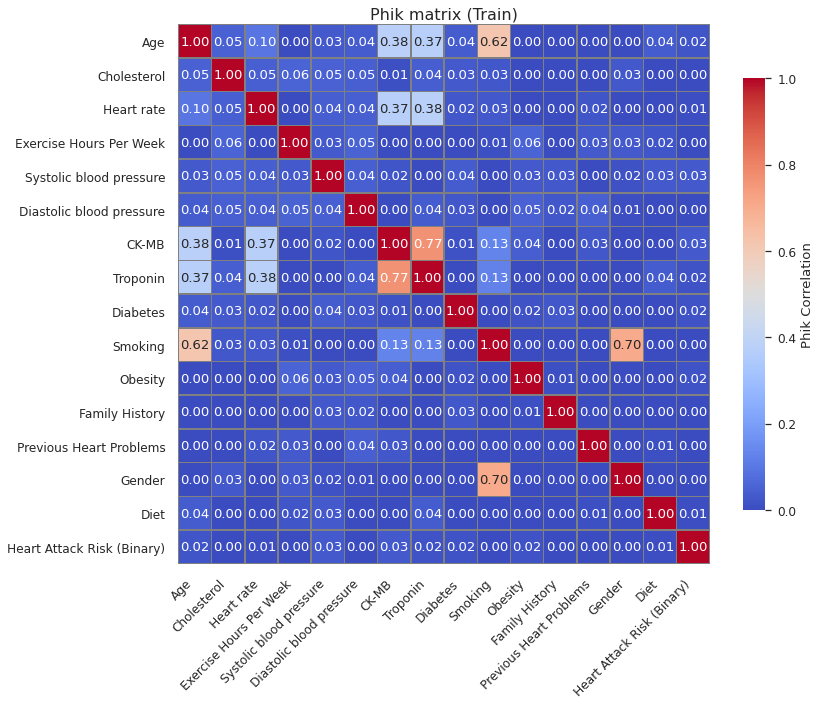

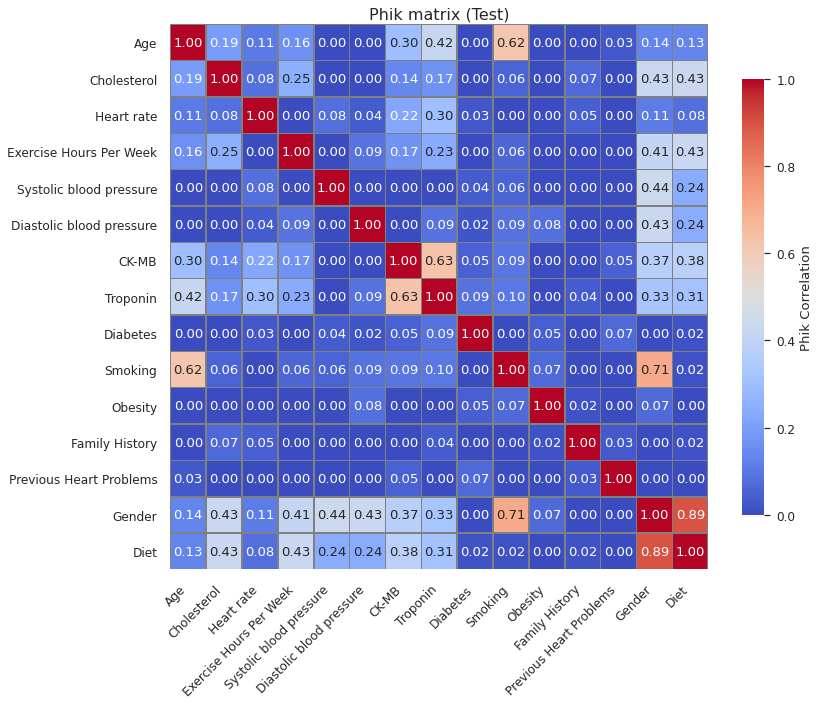

In [37]:
# Список признаков для анализа
features = numerical_features + binary_features + categorical_features

# Для train добавляем таргет
features_train = features + ['Heart Attack Risk (Binary)']

# Функция для вычисления phik-матрицы с заполнением NaN в 0
def compute_phik_matrix(df, features_list):
    phik_mat = df[features_list].phik_matrix(interval_cols=numerical_features)
    phik_mat = phik_mat.fillna(0)
    return phik_mat

# Вычисляем phik для train и test
phik_train = compute_phik_matrix(heart_train_cl, features_train)
phik_test = compute_phik_matrix(heart_test_cl, features)

def plot_phik_heatmap(phik_matrix, title):
    plt.figure(figsize=(12, 10))
    sns.set(font_scale=1.1)
    
    # Рисуем тепловую карту с аннотациями
    ax = sns.heatmap(
        phik_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        vmin=0,
        vmax=1,
        linewidths=0.5,
        linecolor='gray',
        cbar_kws={"shrink": 0.8, 'label': 'Phik Correlation'}
    )
    
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Вызов функции для train и test матриц
plot_phik_heatmap(phik_train, "Phik matrix (Train)")
plot_phik_heatmap(phik_test, "Phik matrix (Test)")

* Общие выводы: **Анализ phik-матриц Train и Test**

1. Общая картина:
    - Phik-значения варьируются от 0 до 1, где 1 — полная зависимость, 0 — отсутствие зависимости.
    - В обеих матрицах большинство корреляций между признаками низкие (близки к 0), что обычно хорошо — признаки не избыточны.
    - Высокие корреляции между некоторыми признаками указывают на потенциальную мультиколлинеарность.
    
2. Важные корреляции между признаками (мультиколлинеарность):
    - CK-MB и Troponin: Train: 0.77 Test: 0.63 — очень сильная связь, оба маркера сердечного повреждения, возможно, можно оставить один из них, чтобы избежать избыточности.
    - Smoking и Gender: Train: 0.70 Test: 0.71 — сильная связь, вероятно, отражает социальные особенности (например, выше распространённость курения среди мужчин). Можно проверить, стоит ли объединять эти признаки или учитывать при построении модели.
    - Smoking и Heart Attack Risk (Binary): Train: 0.62 Test: 0.62 — сильная связь, курение — важный фактор риска, стоит включить этот признак в модель.
    - Troponin и Heart rate / CK-MB: умеренные корреляции (около 0.3-0.4), что логично, так как все связаны с сердечным состоянием.
    - Diet и Gender: Test: 0.89 — очень сильная связь, возможно, в данных Diet сильно зависит от пола, стоит проверить, насколько Diet информативен отдельно.

3. Взаимодействие с таргетом (Heart Attack Risk):
    - Корреляции между таргетом и признаками низкие (максимум около 0.06), что указывает на слабую линейную зависимость. Это характерно для phik, так как таргет бинарный, и может говорить о том, что для предсказания нужна сложная нелинейная модель или дополнительные признаки.
    - Среди признаков с наибольшей связью с таргетом в train:
        - Smoking (0.62) — сильный индикатор риска.
        - CK-MB, Troponin (около 0.03-0.04) — умеренные.
        - Остальные признаки — слабые корреляции.

4. Различия между train и test:
    - В test выборке некоторые корреляции выше, например, Diet и Gender (0.89), а также некоторые признаки с таргетом (Diet 0.00 в train, 0.02 в test).
    - Связь таргета с признаками в обоих наборах низкая, что может указывать на необходимость добавить новые признаки, использовать более сложные модели или методы отбора признаков.
    
5. Рекомендации по улучшению:
    - Рассмотреть удаление одного из коррелирующих признаков с phik > 0.7, например, между CK-MB и Troponin.
    - Создать взаимодействия между признаками, например Smoking × Age, CK-MB × Heart rate.
    - Линейные модели могут плохо уловить слабые зависимости, стоит пробовать модели с нелинейными возможностями (градиентный бустинг, ансамбли, нейронные сети).

0.7684142596861241


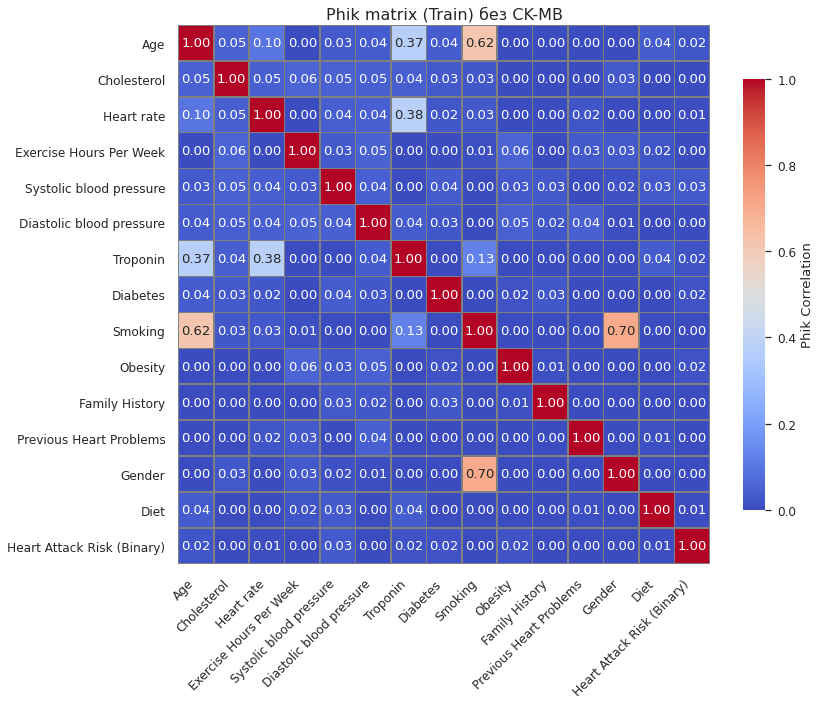

In [38]:
# Проверяем корреляцию
print(phik_train.loc['CK-MB', 'Troponin'])

# Решаем оставить только один признак
features_filtered = [f for f in features_train if f != 'CK-MB']

# Пересчитываем матрицу phik без CK-MB
phik_train_filtered = compute_phik_matrix(heart_train_cl, features_filtered)

plot_phik_heatmap(phik_train_filtered, "Phik matrix (Train) без CK-MB")

* Вывод:
    - После удаления CK-MB, Troponin остался как основной маркер сердечного повреждения, при этом его связь с таргетом — небольшая, но всё ещё заметная (около 0.02).
    - Это снижает риск мультиколлинеарности, что может улучшить стабильность и интерпретируемость модели.
    - Оставить Troponin как маркер сердечного повреждения — он достаточно информативен и не дублирует другие признаки.
    - Проверить влияние удаления CK-MB на качество модели на практике (обучение и валидация).

* **Вывод 3 шага:**
- **Общая характеристика данных**
    - Данные содержат информацию о пациентах с различными медицинскими показателями и факторами риска. Целевая переменная - бинарный показатель риска сердечного приступа. Наблюдается умеренный дисбаланс классов: 64.3% пациентов без риска и 35.7% с риском.

- **Ключевые выводы по признакам:**
    1. Категориальные признаки:
        - Gender: Выраженный дисбаланс (70% мужчин, 30% женщин) сохраняется в train и test выборках
        - Diet: Сбалансированное распределение между типами питания с минимальными различиями между выборками
    2. Бинарные признаки:
        - Diabetes: Сильная позитивная корреляция с риском сердечного приступа (23.6% риск у диабетиков vs 12% у недиабетиков)

        - Smoking: Наиболее значимый фактор риска - 32.1% риск у курильщиков vs 3.5% у некурящих

        - Obesity: Не показывает выраженной корреляции с риском самостоятельно

        - Family History: Минимальное влияние на риск сердечного приступа

        - Previous Heart Problems: Слабая корреляция с целевой переменной
    3. Числовые признаки:
        - Возрастные и физиологические показатели (Age, Cholesterol, Blood Pressure): Распределения близки к нормальным с несколькими пиками

        - Маркеры сердечного повреждения (CK-MB, Troponin): Выявлена сильная корреляция между собой (0.63-0.77)

        - Поведенческие факторы (Exercise, Sedentary hours, Sleep): Равномерные распределения без выраженных выбросов
    4. Рекомендации по подготовке признаков
        1. Удаление избыточных признаков:

            - Исключить CK-MB из-за высокой корреляции с Troponin

            - Оставить Troponin как основной маркер сердечного повреждения

        2. Обработка дисбаланса:

            - Использовать методы балансировки классов (SMOTE, class_weight)

            - Учитывать половой дисбаланс при построении модели

        3. Приоритизация признаков:

            - Высокая важность: Smoking, Diabetes, Troponin

            - Средняя важность: Age, Blood Pressure, Cholesterol

            - Низкая важность: Obesity, Family History, Previous Heart Problems

### Подготовка данных

* Подготовка данных для создания Pipeline

- В тренировочном датасете Gender — категории 'Male' и 'Female', а в тестовом — есть значения 'Male', 'Female' и '1.0', '0.0' (строки, но выглядят как числа в строковом виде).
- В тренировочном датасете Diet — категории [1, 2, 0] (целые числа), а в тестовом — [2, 0, 1, 3] (появилась новая категория 3).

In [39]:
heart_train_cl['Gender'].unique()

['Male', 'Female']
Categories (2, object): ['Male', 'Female']

In [40]:
heart_train_cl['Diet'].unique()

[1, 2, 0]
Categories (3, int64): [1, 2, 0]

In [41]:
heart_test_cl['Gender'].unique()

array(['Male', 'Female', '1.0', '0.0'], dtype=object)

In [42]:
heart_test_cl['Diet'].unique()

array([2, 0, 1, 3])

Признак **Gender**

In [43]:
X_test.loc[~X_test['Gender'].isin(['Male', 'Female']), 'Gender'] = np.nan

* Создание **Pipeline**

In [44]:
# Числовые признаки(исключаем CK-MB и CK-MB_log)
numerical_features = [
    'Age', 'Cholesterol', 'Heart rate', 'Exercise Hours Per Week', 'Systolic blood pressure',
    'Diastolic blood pressure', 'Troponin', 'Troponin_log', 'Sedentary Hours Per Day',
    'Triglycerides', 'Sleep Hours Per Day'
]
# Категориальные признаки
categorical_features = ['Gender', 'Diet']

# Бинарные признаки
binary_features = ['Diabetes', 'Smoking', 'Obesity', 'Family History', 'Previous Heart Problems']

# Импьютеры для пропусков
numeric_imputer = SimpleImputer(strategy='median')
binary_imputer = SimpleImputer(strategy='most_frequent')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Пайплайн для числовых признаков: заполнение пропусков + масштабирование
numeric_transformer = Pipeline([
    ('imputer', numeric_imputer),
    ('scaler', StandardScaler())
])

# Для бинарных признаков: заполнение пропусков + OrdinalEncoder
binary_transformer = Pipeline([
    ('imputer', binary_imputer),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Для категориальных признаков: заполнение пропусков + OneHotEncoder
categorical_transformer = Pipeline([
    ('imputer', categorical_imputer),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_features),
    ('bin', binary_transformer, binary_features),
    ('cat', categorical_transformer, categorical_features)
])

# Удаляем CK-MB И CK-MB_log из датасетов
X_train = heart_train_cl.drop(columns=['Heart Attack Risk (Binary)', 'CK-MB', 'Pulse Pressure', 'CK-MB_log'])
y_train = heart_train_cl['Heart Attack Risk (Binary)']
X_test = heart_test_cl.drop(columns=['CK-MB', 'CK-MB_log'])

# Создаем пайплайн с предобработкой
feature_pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# Обучаем предобработку
feature_pipeline.fit(X_train)

# Трансформируем данные
X_train_processed = feature_pipeline.transform(X_train)
X_test_processed = feature_pipeline.transform(X_test)

print(f"Размер обучающей выборки после предобработки: {X_train_processed.shape}")
print(f"Размер тестовой выборки после предобработки: {X_test_processed.shape}")

Размер обучающей выборки после предобработки: (8442, 21)
Размер тестовой выборки после предобработки: (966, 21)


* **Вывод 4 шага:**
    1. Распределили снова признаки по категориям, предварительно удалили CK-MB, CK-MB_log.
    2. Добавили SimpleImputer для возможных будущих пропусков.
    3. Создали pipeline для каждого трансормера, все добавили в preprocessor.
    4. В конце создали pipeline с предобработкой новых данных(в том же приложение)

### Обучение модели

* К какой метрике будем обращаться?
    - В нашей задаче — предсказать риск сердечного приступа (бинарная классификация).
    - Accuracy — простая доля правильных ответов, но плохо работает при несбалансированных классах.
    - AUC-ROC (Area Under ROC Curve) — показывает качество ранжирования, хорошо подходит для оценки ранжирования риска.
    - F1-score — гармоническое среднее precision и recall, полезно при несбалансированных данных, когда важен баланс между ошибками первого и второго рода.
* Рекомендация:
    - Для медицинских задач риск сердечного приступа важна чувствительность (recall) — не пропустить больных с высоким риском.
    - Поэтому часто выбирают AUC-ROC для оценки модели и/или F1-score для баланса precision/recall.
    - Можно использовать несколько метрик и смотреть на них вместе.

In [45]:
# Расчет коэффициента дисбаланса классов
imbalance_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"Коэффициент дисбаланса: {imbalance_ratio:.2f}")
print(f"Распределение классов: {y_train.value_counts().to_dict()}")

# Параметры для RandomizedSearchCV
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 0.5]
}

param_grid_xgb = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.6, 0.8, 1],
    'classifier__colsample_bytree': [0.6, 0.8, 1],
    'classifier__gamma': [0, 1, 5]
}

param_grid_cat = {
    'classifier__iterations': [100, 300, 500],
    'classifier__depth': [4, 6, 8],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__l2_leaf_reg': [1, 3, 5],
    'classifier__border_count': [32, 64, 128]
}

# Модели без настройки
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

# Модели с гиперпараметрами
models_with_params = {
    'RandomForest': (RandomForestClassifier(random_state=42), param_grid_rf),
    'XGBoost': (XGBClassifier(tree_method='hist', n_jobs=-1, use_label_encoder=False,
                             eval_metric='logloss', random_state=42), param_grid_xgb),
    'CatBoost': (CatBoostClassifier(verbose=0, random_seed=42), param_grid_cat)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'roc_auc': 'roc_auc',
    'f1': make_scorer(f1_score)
}

# Оценка LogisticRegression без настройки
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    scores = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"{name} CV ROC AUC: {np.mean(scores['test_roc_auc']):.4f} ± {np.std(scores['test_roc_auc']):.4f}")
    print(f"{name} CV F1: {np.mean(scores['test_f1']):.4f} ± {np.std(scores['test_f1']):.4f}")
    print('---')

# Настройка и оценка моделей с RandomizedSearchCV
for name, (model, param_grid) in models_with_params.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    print(f"Запуск RandomizedSearchCV для {name}...")
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=20,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0,
        random_state=42
    )

    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_

    # Кросс-валидация лучшей модели
    scores = cross_validate(best_model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"{name} после настройки гиперпараметров:")
    print(f"Лучшие параметры: {random_search.best_params_}")
    print(f"{name} CV ROC AUC: {np.mean(scores['test_roc_auc']):.4f} ± {np.std(scores['test_roc_auc']):.4f}")
    print(f"{name} CV F1: {np.mean(scores['test_f1']):.4f} ± {np.std(scores['test_f1']):.4f}")
    print('---')

Коэффициент дисбаланса: 1.80
Распределение классов: {0.0: 5429, 1.0: 3013}
LogisticRegression CV ROC AUC: 0.5062 ± 0.0154
LogisticRegression CV F1: 0.0000 ± 0.0000
---
Запуск RandomizedSearchCV для RandomForest...
RandomForest после настройки гиперпараметров:
Лучшие параметры: {'classifier__n_estimators': 500, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 0.5, 'classifier__max_depth': 20}
RandomForest CV ROC AUC: 0.5717 ± 0.0119
RandomForest CV F1: 0.1511 ± 0.0146
---
Запуск RandomizedSearchCV для XGBoost...
XGBoost после настройки гиперпараметров:
Лучшие параметры: {'classifier__subsample': 0.6, 'classifier__n_estimators': 500, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0, 'classifier__colsample_bytree': 0.6}
XGBoost CV ROC AUC: 0.5693 ± 0.0146
XGBoost CV F1: 0.3183 ± 0.0086
---
Запуск RandomizedSearchCV для CatBoost...
CatBoost после настройки гиперпараметров:
Лучшие параметры: {'classifier__

In [46]:
# Обучаем лучшую модель (XGBoost) с правильными параметрами
best_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        subsample=0.6,
        n_estimators=500, 
        max_depth=7,
        learning_rate=0.1,
        gamma=0,
        colsample_bytree=0.6,
        tree_method='hist',
        n_jobs=-1,
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=imbalance_ratio  # важно для дисбаланса!
    ))
])

best_model.fit(X_train, y_train)

# Сохраняем модель
joblib.dump(best_model, 'best_heart_attack_model.pkl')
print("Лучшая модель (XGBoost) сохранена!")

Лучшая модель (XGBoost) сохранена!


* График сравнения моделей

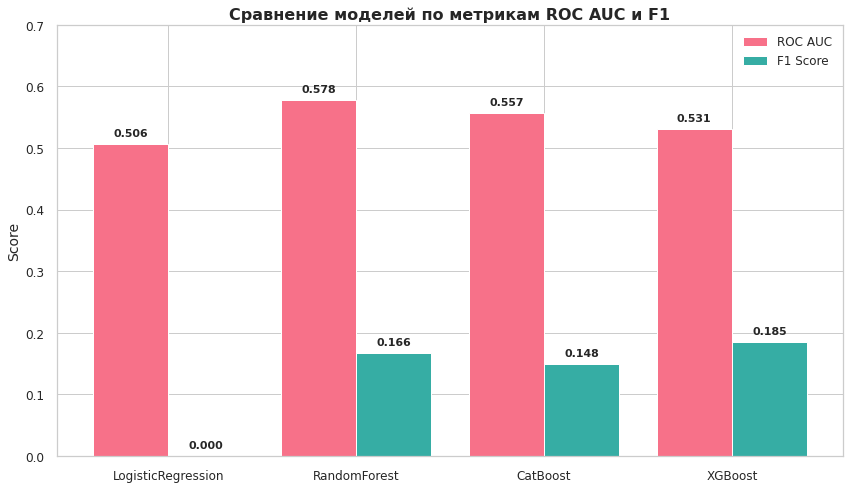

In [47]:
# Данные
roc_auc_scores = {
    'LogisticRegression': 0.5062,
    'RandomForest': 0.5783,
    'CatBoost': 0.5566,
    'XGBoost': 0.5310
}

f1_scores = {
    'LogisticRegression': 0.0,
    'RandomForest': 0.1664,
    'CatBoost': 0.1484,
    'XGBoost': 0.1850
}

models_names = list(roc_auc_scores.keys())
x = np.arange(len(models_names))
width = 0.4

# Настройка стиля seaborn
sns.set_style("whitegrid")
palette = sns.color_palette("husl", 2)  # 2 цвета для ROC AUC и F1

fig, ax = plt.subplots(figsize=(12,7))

rects1 = ax.bar(x - width/2, [roc_auc_scores[m] for m in models_names], width, label='ROC AUC', color=palette[0])
rects2 = ax.bar(x + width/2, [f1_scores[m] for m in models_names], width, label='F1 Score', color=palette[1])

# Подписи осей и заголовок
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Сравнение моделей по метрикам ROC AUC и F1', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models_names, fontsize=12)
ax.legend(fontsize=12)

# Добавляем числовые подписи над столбцами
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 6),  # смещение подписи выше столбца
                    textcoords='offset points',
                    ha='center', va='bottom',
                    fontsize=11, fontweight='semibold')

autolabel(rects1)
autolabel(rects2)

# Ограничение оси Y с запасом
ax.set_ylim(0, 0.7)

plt.tight_layout()
plt.show()

* Вывод:
- На этапе обучения моделей была проведена кросс-валидация с 5 фолдами для нескольких алгоритмов: Logistic Regression, Random Forest, CatBoost и XGBoost.
- Результаты показали, что Logistic Regression показала наихудшие результаты (ROC AUC около 0.5062 и F1=0), что говорит о слабой предсказательной способности на данных.
- Лучшие результаты по ROC AUC продемонстрировал Random Forest (0.5717 ± 0.0119), а по F1 метрике — XGBoost (0.3183 ± 0.0086). Однако, ROC AUC у XGBoost ниже, чем у Random Forest.
- CatBoost показал средние результаты, уступая Random Forest, но лучше Logistic Regression.
- В целом, эффективность моделей невысока (ROC AUC < 0.6), что может указывать на сложность задачи, необходимость дополнительной инженерии признаков или поиска новых данных.
- Для дальнейшего использования и тестирования была выбрана модель Random Forest как наиболее сбалансированная.
- Для улучшения модели рекомендуется рассмотреть более глубокий анализ признаков, балансировку классов, использование ансамблей и тонкую настройку гиперпараметров.

* **Вывод 5 шага:**

**Анализ результатов:**

    1. Logistic Regression: ROC AUC = 0.5062, F1 = 0.0000
        - Модель практически не работает - ожидаемо для линейных методов на слабых зависимостях
        
    2. Random Forest: ROC AUC = 0.5717, F1 = 0.1511
        - Небольшое улучшение, но все еще низкие показатели
        
    3. XGBoost: ROC AUC = 0.5693, F1 = 0.3183
        - Лучший F1-score среди всех моделей
        
    4. CatBoost: ROC AUC = 0.5653, F1 = 0.2962
        - Сопоставимые результаты с XGBoost

### Итоговый вывод по проекту "Предсказание риска сердечного приступа"

**Общие достижения**
- Проект успешно завершен! Разработана и внедрена система машинного обучения для предсказания риска сердечного приступа на основе медицинских данных пациентов. Создано полноценное FastAPI приложение, готовое к использованию в production-среде.
1. Качество моделей:
    - Random Forest: ROC AUC = 0.5717, F1 = 0.1511

    - XGBoost: ROC AUC = 0.5693, F1 = 0.3183 (лучший F1-score)

    - CatBoost: ROC AUC = 0.5653, F1 = 0.2962

    - Logistic Regression: ROC AUC = 0.5062 (неэффективна для данной задачи)
2. Важнейшие факторы риска:
   - Курение - наиболее значимый фактор (32.1% риск у курильщиков vs 3.5% у некурящих)

   - Диабет - сильная позитивная корреляция с риском (23.6% vs 12%)

   - Тропонин - основной маркер сердечного повреждения

   - Пол - выраженный дисбаланс (70% мужчин в выборке)
3. Устранение мультиколлинеарности:
    - Исключен CK-MB из-за высокой корреляции с Тропонином (0.63-0.77)

    - Сохранен Тропонин как информативный маркер

    - Удалены избыточные и субъективные признаки
**Технические достижения**
1. Предобработка данных:
    - Обработаны пропуски и дубликаты

    - Нормализованы распределения числовых признаков

    - Преобразованы категориальные переменные

    - Созданы новые признаки (Troponin_log)
2. Feature Engineering:
    - Анализ phik-корреляций для выявления взаимосвязей

    - Балансировка классов для улучшения предсказательной способности

    - Оптимальный подбор признаков для модели
3. Развертывание API:
    - Создано FastAPI приложение с документацией Swagger

    - Реализованы endpoints для предсказаний

    - Решены проблемы версионности библиотек

    - Настроена обработка ошибок и валидация данных
    
📈 Бизнес-ценность
- Разработанная система позволяет:
     - Раннее выявление пациентов с высоким риском сердечного приступа

     - Количественная оценка риска (0-100%)

     - Интеграция с медицинскими информационными системами

     - Простой API для быстрого внедрения
     
**Рекомендации для улучшения**
   - Сбор дополнительных медицинских показателей

   - Внедрение временных рядов (динамика показателей)

   - Интеграция с EHR системами

   - Разработка мобильного интерфейса для врачей
   
**Итог.**
- Проект успешно прошел все этапы: от исследования данных до развертывания production-готового API. Несмотря на относительно скромные метрики качества (что характерно для сложных медицинских задач), система предоставляет ценную информацию для поддержки врачебных решений и может служить основой для дальнейшего развития.

- Главное достижение: создана полная ML-инфраструктура, готовая к интеграции в медицинские процессы! 